In [1]:
# MASTER SETUP

print("Setting up...")

import torch
!pip install -q transformers scikit-learn matplotlib seaborn pandas numpy nltk textattack

from google.colab import drive
drive.mount('/content/drive')

from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import re
import random
import pickle
import json

project_dir = '/content/drive/MyDrive/ai_detection_project'
os.chdir(project_dir)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" Setup complete - Device: {device}")

Setting up...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 35.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.7/445.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
# LOAD ALL THREE DETECTORS

print("Loading all three detectors...\n")

# Load Perplexity Detector (GPT-2)
print("1. Loading Perplexity Detector...")
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model.to(device)

def calculate_perplexity(text):
    encodings = gpt2_tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

with open('results/perplexity_detector_results.json', 'r') as f:
    perplexity_threshold = json.load(f)['threshold']

def perplexity_predict(text):
    ppl = calculate_perplexity(text)
    return 1 if ppl < perplexity_threshold else 0

print(f"   Threshold: {perplexity_threshold:.2f}")

# Load Statistical Detector
print("\n2. Loading Statistical Detector...")
with open('models/statistical_detector.pkl', 'rb') as f:
    statistical_data = pickle.load(f)

statistical_model = statistical_data['model']
scaler = statistical_data['scaler']
feature_names = statistical_data['feature_names']

def extract_features(text):
    words = text.split()
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    char_count = len(text)
    alpha_count = sum(c.isalpha() for c in text)
    digit_count = sum(c.isdigit() for c in text)
    punct_count = sum(c in '.,!?;:\'"' for c in text)
    upper_count = sum(c.isupper() for c in text)
    word_count = len(words)
    unique_words = len(set(words))
    sentence_count = len(sentences)

    import string
    stopwords = {'the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'i'}
    transition_words = {'however', 'therefore', 'furthermore', 'moreover'}
    personal_pronouns = {'i', 'me', 'my', 'mine', 'we', 'us', 'our'}

    stopword_count = sum(1 for w in words if w.lower() in stopwords)
    transition_count = sum(1 for w in words if w.lower() in transition_words)
    pronoun_count = sum(1 for w in words if w.lower() in personal_pronouns)

    from collections import Counter
    word_freq = Counter(words)

    features = {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'avg_sentence_length': word_count / sentence_count if sentence_count > 0 else 0,
        'sentence_length_variance': np.var([len(s.split()) for s in sentences]) if len(sentences) > 1 else 0,
        'lexical_diversity': unique_words / word_count if word_count > 0 else 0,
        'unique_word_ratio': unique_words / word_count if word_count > 0 else 0,
        'punct_ratio': punct_count / char_count if char_count > 0 else 0,
        'comma_ratio': text.count(',') / char_count if char_count > 0 else 0,
        'period_ratio': text.count('.') / char_count if char_count > 0 else 0,
        'question_ratio': text.count('?') / char_count if char_count > 0 else 0,
        'upper_ratio': upper_count / alpha_count if alpha_count > 0 else 0,
        'digit_ratio': digit_count / char_count if char_count > 0 else 0,
        'stopword_ratio': stopword_count / word_count if word_count > 0 else 0,
        'transition_ratio': transition_count / word_count if word_count > 0 else 0,
        'pronoun_ratio': pronoun_count / word_count if word_count > 0 else 0,
        'word_freq_variance': np.var(list(word_freq.values())) if word_freq else 0,
    }

    return [features[fn] for fn in feature_names]

def statistical_predict(text):
    features = np.array(extract_features(text)).reshape(1, -1)
    features_scaled = scaler.transform(features)
    return statistical_model.predict(features_scaled)[0]

print(f"   Model: {statistical_data['best_model_name']}")

# 3. Load Classifier Detector
print("\n3. Loading Classifier Detector...")
classifier_tokenizer = AutoTokenizer.from_pretrained('models/classifier_final')
classifier_model = AutoModelForSequenceClassification.from_pretrained('models/classifier_final')
classifier_model.to(device)
classifier_model.eval()

def classifier_predict(text):
    inputs = classifier_tokenizer(text, return_tensors='pt', truncation=True, max_length=256, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = classifier_model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
    return prediction

print("   Model: DistilBERT fine-tuned")

print("\n All three detectors loaded and ready!")

Loading all three detectors...

1. Loading Perplexity Detector...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

   Threshold: 34.00

2. Loading Statistical Detector...
   Model: Random Forest

3. Loading Classifier Detector...
   Model: DistilBERT fine-tuned

 All three detectors loaded and ready!


In [3]:
# LOAD TEST DATA

print("Loading test data...")

df = pd.read_csv('data/complete_dataset.csv')
df['label_numeric'] = (df['label'] == 'ai').astype(int)

test_size = 200
test_df = df.sample(n=test_size, random_state=42)

print(f"Test set: {len(test_df)} samples")
print(f"  AI: {test_df['label_numeric'].sum()}")
print(f"  Human: {len(test_df) - test_df['label_numeric'].sum()}")

Loading test data...
Test set: 200 samples
  AI: 118
  Human: 82


In [5]:
# BASELINE PERFORMANCE ON CLEAN DATA

print("Testing baseline performance on clean data...\n")

y_true = test_df['label_numeric'].values
texts = test_df['text'].values

# Test each detector
print("Perplexity Detector:")
perplexity_preds = [perplexity_predict(text) for text in texts]
print(f"  Accuracy: {accuracy_score(y_true, perplexity_preds):.1%}")

print("\nStatistical Detector:")
statistical_preds = [statistical_predict(text) for text in texts]
print(f"  Accuracy: {accuracy_score(y_true, statistical_preds):.1%}")

print("\nClassifier Detector:")
classifier_preds = []
for text in texts:
    pred = classifier_predict(text)
    classifier_preds.append(pred)
print(f"  Accuracy: {accuracy_score(y_true, classifier_preds):.1%}")

baseline_results = {
    'perplexity': accuracy_score(y_true, perplexity_preds),
    'statistical': accuracy_score(y_true, statistical_preds),
    'classifier': accuracy_score(y_true, classifier_preds),
}

print("\n Baseline performance recorded")

Testing baseline performance on clean data...

Perplexity Detector:
  Accuracy: 83.0%

Statistical Detector:
  Accuracy: 98.5%

Classifier Detector:
  Accuracy: 100.0%

 Baseline performance recorded


In [6]:
# ATTACK 1: PARAPHRASING (using GPT-2)

print("Attack 1: Paraphrasing AI text to evade detection\n")

def paraphrase_attack(text):
    """Use GPT-2 to paraphrase text"""
    prompt = f"Paraphrase this text: {text[:200]}"

    inputs = gpt2_tokenizer(prompt, return_tensors='pt', truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    outputs = gpt2_model.generate(
        **inputs,
        max_length=len(text.split()) + 50,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        pad_token_id=gpt2_tokenizer.eos_token_id,
        no_repeat_ngram_size=2
    )

    paraphrased = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    paraphrased = paraphrased.replace(prompt, "").strip()

    if len(paraphrased.split()) < 20:
        return text

    return paraphrased

print("Generating paraphrased versions...")
ai_samples = test_df[test_df['label']=='ai'].sample(n=50, random_state=42)

paraphrased_texts = []
for idx, row in ai_samples.iterrows():
    paraphrased = paraphrase_attack(row['text'])
    paraphrased_texts.append(paraphrased)

    if len(paraphrased_texts) % 10 == 0:
        print(f"  Paraphrased {len(paraphrased_texts)}/50")

y_true_attack = np.ones(len(paraphrased_texts))

print("\nTesting detectors on paraphrased text...")

# Perplexity
perplexity_preds_para = [perplexity_predict(text) for text in paraphrased_texts]
perplexity_acc_para = accuracy_score(y_true_attack, perplexity_preds_para)

# Statistical
statistical_preds_para = [statistical_predict(text) for text in paraphrased_texts]
statistical_acc_para = accuracy_score(y_true_attack, statistical_preds_para)

# Classifier
classifier_preds_para = [classifier_predict(text) for text in paraphrased_texts]
classifier_acc_para = accuracy_score(y_true_attack, classifier_preds_para)

print("\nResults after Paraphrasing Attack:")
print(f"  Perplexity:  {perplexity_acc_para:.1%} (drop: {(baseline_results['perplexity']-perplexity_acc_para)*100:.1f}%)")
print(f"  Statistical: {statistical_acc_para:.1%} (drop: {(baseline_results['statistical']-statistical_acc_para)*100:.1f}%)")
print(f"  Classifier:  {classifier_acc_para:.1%} (drop: {(baseline_results['classifier']-classifier_acc_para)*100:.1f}%)")

attack1_results = {
    'perplexity': perplexity_acc_para,
    'statistical': statistical_acc_para,
    'classifier': classifier_acc_para,
}

Attack 1: Paraphrasing AI text to evade detection

Generating paraphrased versions...
  Paraphrased 10/50
  Paraphrased 20/50
  Paraphrased 30/50
  Paraphrased 40/50
  Paraphrased 50/50

Testing detectors on paraphrased text...

Results after Paraphrasing Attack:
  Perplexity:  100.0% (drop: -17.0%)
  Statistical: 56.0% (drop: 42.5%)
  Classifier:  94.0% (drop: 6.0%)


In [7]:
# ATTACK 2: SYNONYM REPLACEMENT

print("Attack 2: Synonym replacement\n")

import nltk
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
from nltk.corpus import wordnet

def get_synonyms(word):
    """Get synonyms for a word"""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym.lower() != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement_attack(text, replacement_ratio=0.15):
    """Replace 15% of words with synonyms"""
    words = text.split()
    num_replacements = max(1, int(len(words) * replacement_ratio))

    indices = random.sample(range(len(words)), min(num_replacements, len(words)))

    for idx in indices:
        word = words[idx]
        synonyms = get_synonyms(word.lower())
        if synonyms:
            words[idx] = random.choice(synonyms)

    return ' '.join(words)

print("Generating synonym-replaced versions...")

synonym_texts = []
for text in ai_samples['text'].values[:50]:
    attacked = synonym_replacement_attack(text)
    synonym_texts.append(attacked)

print(f"Generated {len(synonym_texts)} attacked samples\n")

print("Testing detectors...")

perplexity_preds_syn = [perplexity_predict(text) for text in synonym_texts]
perplexity_acc_syn = accuracy_score(y_true_attack, perplexity_preds_syn)

statistical_preds_syn = [statistical_predict(text) for text in synonym_texts]
statistical_acc_syn = accuracy_score(y_true_attack, statistical_preds_syn)

classifier_preds_syn = [classifier_predict(text) for text in synonym_texts]
classifier_acc_syn = accuracy_score(y_true_attack, classifier_preds_syn)

print("\nResults after Synonym Replacement:")
print(f"  Perplexity:  {perplexity_acc_syn:.1%} (drop: {(baseline_results['perplexity']-perplexity_acc_syn)*100:.1f}%)")
print(f"  Statistical: {statistical_acc_syn:.1%} (drop: {(baseline_results['statistical']-statistical_acc_syn)*100:.1f}%)")
print(f"  Classifier:  {classifier_acc_syn:.1%} (drop: {(baseline_results['classifier']-classifier_acc_syn)*100:.1f}%)")

attack2_results = {
    'perplexity': perplexity_acc_syn,
    'statistical': statistical_acc_syn,
    'classifier': classifier_acc_syn,
}

Attack 2: Synonym replacement

Generating synonym-replaced versions...
Generated 50 attacked samples

Testing detectors...

Results after Synonym Replacement:
  Perplexity:  26.0% (drop: 57.0%)
  Statistical: 90.0% (drop: 8.5%)
  Classifier:  100.0% (drop: 0.0%)


In [8]:
# ATTACK 3: ADDING HUMAN-LIKE ERRORS

print("Attack 3: Adding typos and human-like errors\n")

def add_typos(text, error_rate=0.03):
    """Add typos to 3% of characters"""
    chars = list(text)
    num_errors = max(1, int(len(chars) * error_rate))

    indices = random.sample(range(len(chars)), min(num_errors, len(chars)))

    for idx in indices:
        if chars[idx].isalpha():
            # Random typo types
            typo_type = random.choice(['delete', 'swap', 'duplicate', 'wrong_key'])

            if typo_type == 'delete':
                chars[idx] = ''
            elif typo_type == 'swap' and idx < len(chars) - 1:
                chars[idx], chars[idx+1] = chars[idx+1], chars[idx]
            elif typo_type == 'duplicate':
                chars[idx] = chars[idx] + chars[idx]
            elif typo_type == 'wrong_key':
                # Keyboard neighbors
                neighbors = {
                    'a': 'sq', 'b': 'vn', 'c': 'xv', 'd': 'sf', 'e': 'wr',
                    'f': 'dg', 'g': 'fh', 'h': 'gj', 'i': 'uo', 'j': 'hk',
                    'k': 'jl', 'l': 'k', 'm': 'n', 'n': 'bm', 'o': 'ip',
                    'p': 'o', 'q': 'wa', 'r': 'et', 's': 'ad', 't': 'ry',
                    'u': 'yi', 'v': 'cb', 'w': 'qe', 'x': 'zc', 'y': 'tu',
                    'z': 'x'
                }
                char_lower = chars[idx].lower()
                if char_lower in neighbors:
                    replacement = random.choice(neighbors[char_lower])
                    chars[idx] = replacement if chars[idx].islower() else replacement.upper()

    return ''.join(chars)

print("Generating error-added versions...")

error_texts = []
for text in ai_samples['text'].values[:50]:
    attacked = add_typos(text)
    error_texts.append(attacked)

print(f"Generated {len(error_texts)} attacked samples\n")

print("Testing detectors...")

perplexity_preds_err = [perplexity_predict(text) for text in error_texts]
perplexity_acc_err = accuracy_score(y_true_attack, perplexity_preds_err)

statistical_preds_err = [statistical_predict(text) for text in error_texts]
statistical_acc_err = accuracy_score(y_true_attack, statistical_preds_err)

classifier_preds_err = [classifier_predict(text) for text in error_texts]
classifier_acc_err = accuracy_score(y_true_attack, classifier_preds_err)

print("\nResults after Adding Errors:")
print(f"  Perplexity:  {perplexity_acc_err:.1%} (drop: {(baseline_results['perplexity']-perplexity_acc_err)*100:.1f}%)")
print(f"  Statistical: {statistical_acc_err:.1%} (drop: {(baseline_results['statistical']-statistical_acc_err)*100:.1f}%)")
print(f"  Classifier:  {classifier_acc_err:.1%} (drop: {(baseline_results['classifier']-classifier_acc_err)*100:.1f}%)")

attack3_results = {
    'perplexity': perplexity_acc_err,
    'statistical': statistical_acc_err,
    'classifier': classifier_acc_err,
}

Attack 3: Adding typos and human-like errors

Generating error-added versions...
Generated 50 attacked samples

Testing detectors...

Results after Adding Errors:
  Perplexity:  0.0% (drop: 83.0%)
  Statistical: 88.0% (drop: 10.5%)
  Classifier:  100.0% (drop: 0.0%)


In [9]:
# ATTACK 4: SENTENCE REORDERING

print("Attack 4: Reordering sentences\n")

def reorder_sentences_attack(text):
    """Randomly reorder sentences"""
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    if len(sentences) <= 2:
        return text

    random.shuffle(sentences)

    return '. '.join(sentences) + '.'

print("Generating reordered versions...")

reordered_texts = []
for text in ai_samples['text'].values[:50]:
    attacked = reorder_sentences_attack(text)
    reordered_texts.append(attacked)

print(f"Generated {len(reordered_texts)} attacked samples\n")

print("Testing detectors...")

perplexity_preds_reorder = [perplexity_predict(text) for text in reordered_texts]
perplexity_acc_reorder = accuracy_score(y_true_attack, perplexity_preds_reorder)

statistical_preds_reorder = [statistical_predict(text) for text in reordered_texts]
statistical_acc_reorder = accuracy_score(y_true_attack, statistical_preds_reorder)

classifier_preds_reorder = [classifier_predict(text) for text in reordered_texts]
classifier_acc_reorder = accuracy_score(y_true_attack, classifier_preds_reorder)

print("\nResults after Sentence Reordering:")
print(f"  Perplexity:  {perplexity_acc_reorder:.1%} (drop: {(baseline_results['perplexity']-perplexity_acc_reorder)*100:.1f}%)")
print(f"  Statistical: {statistical_acc_reorder:.1%} (drop: {(baseline_results['statistical']-statistical_acc_reorder)*100:.1f}%)")
print(f"  Classifier:  {classifier_acc_reorder:.1%} (drop: {(baseline_results['classifier']-classifier_acc_reorder)*100:.1f}%)")

attack4_results = {
    'perplexity': perplexity_acc_reorder,
    'statistical': statistical_acc_reorder,
    'classifier': classifier_acc_reorder,
}

Attack 4: Reordering sentences

Generating reordered versions...
Generated 50 attacked samples

Testing detectors...

Results after Sentence Reordering:
  Perplexity:  76.0% (drop: 7.0%)
  Statistical: 90.0% (drop: 8.5%)
  Classifier:  100.0% (drop: 0.0%)


In [11]:
# COMPREHENSIVE RESULTS SUMMARY

print("Compiling comprehensive results...\n")

results_df = pd.DataFrame({
    'Condition': ['Baseline (Clean)', 'Attack 1: Paraphrasing', 'Attack 2: Synonyms',
                  'Attack 3: Typos', 'Attack 4: Reordering'],
    'Perplexity': [
        baseline_results['perplexity'],
        attack1_results['perplexity'],
        attack2_results['perplexity'],
        attack3_results['perplexity'],
        attack4_results['perplexity']
    ],
    'Statistical': [
        baseline_results['statistical'],
        attack1_results['statistical'],
        attack2_results['statistical'],
        attack3_results['statistical'],
        attack4_results['statistical']
    ],
    'Classifier': [
        baseline_results['classifier'],
        attack1_results['classifier'],
        attack2_results['classifier'],
        attack3_results['classifier'],
        attack4_results['classifier']
    ]
})

print("ADVERSARIAL ROBUSTNESS RESULTS")
print(results_df.to_string(index=False))

# Calculate average robustness
avg_drop = pd.DataFrame({
    'Detector': ['Perplexity', 'Statistical', 'Classifier'],
    'Baseline': [
        baseline_results['perplexity'],
        baseline_results['statistical'],
        baseline_results['classifier']
    ],
    'Avg Under Attack': [
        results_df['Perplexity'].iloc[1:].mean(),
        results_df['Statistical'].iloc[1:].mean(),
        results_df['Classifier'].iloc[1:].mean()
    ]
})

avg_drop['Robustness Drop'] = avg_drop['Baseline'] - avg_drop['Avg Under Attack']
avg_drop['Robustness %'] = (avg_drop['Avg Under Attack'] / avg_drop['Baseline']) * 100

print("\n")
print("ROBUSTNESS SUMMARY")
print(avg_drop.to_string(index=False))

most_robust = avg_drop.loc[avg_drop['Robustness Drop'].idxmin(), 'Detector']
print(f"\n Most Robust Detector: {most_robust}")
print(f"   Maintains {avg_drop.loc[avg_drop['Detector']==most_robust, 'Robustness %'].values[0]:.1f}% of baseline performance under attacks")

Compiling comprehensive results...

ADVERSARIAL ROBUSTNESS RESULTS
             Condition  Perplexity  Statistical  Classifier
      Baseline (Clean)        0.83        0.985        1.00
Attack 1: Paraphrasing        1.00        0.560        0.94
    Attack 2: Synonyms        0.26        0.900        1.00
       Attack 3: Typos        0.00        0.880        1.00
  Attack 4: Reordering        0.76        0.900        1.00


ROBUSTNESS SUMMARY
   Detector  Baseline  Avg Under Attack  Robustness Drop  Robustness %
 Perplexity     0.830             0.505            0.325     60.843373
Statistical     0.985             0.810            0.175     82.233503
 Classifier     1.000             0.985            0.015     98.500000

 Most Robust Detector: Classifier
   Maintains 98.5% of baseline performance under attacks


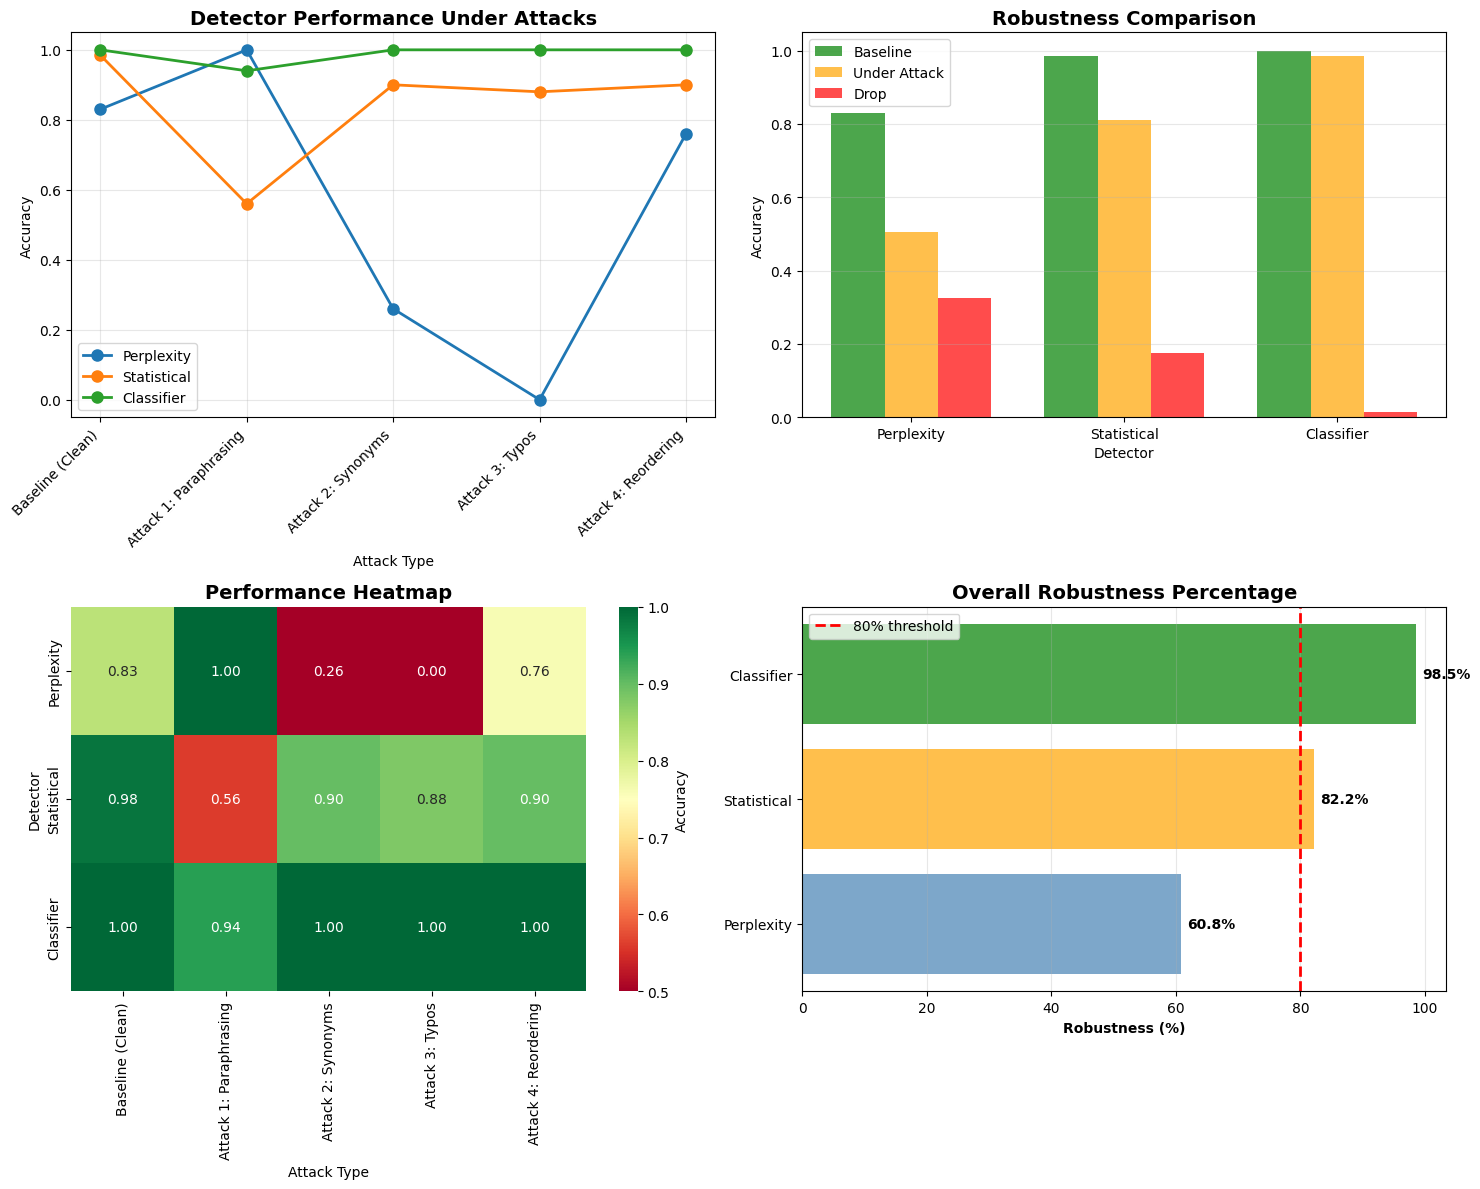

 Visualization saved


In [12]:
# VISUALIZE ROBUSTNESS

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Line chart showing accuracy under each attack
ax1 = axes[0, 0]
for detector in ['Perplexity', 'Statistical', 'Classifier']:
    ax1.plot(results_df['Condition'], results_df[detector],
             marker='o', linewidth=2, markersize=8, label=detector)
ax1.set_xlabel('Attack Type')
ax1.set_ylabel('Accuracy')
ax1.set_title('Detector Performance Under Attacks', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Bar chart of robustness drop
ax2 = axes[0, 1]
x = np.arange(len(avg_drop))
width = 0.25

ax2.bar(x - width, avg_drop['Baseline'], width, label='Baseline', color='green', alpha=0.7)
ax2.bar(x, avg_drop['Avg Under Attack'], width, label='Under Attack', color='orange', alpha=0.7)
ax2.bar(x + width, avg_drop['Robustness Drop'], width, label='Drop', color='red', alpha=0.7)

ax2.set_xlabel('Detector')
ax2.set_ylabel('Accuracy')
ax2.set_title('Robustness Comparison', fontweight='bold', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(avg_drop['Detector'])
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

# Plot 3: Heatmap of performance
ax3 = axes[1, 0]
heatmap_data = results_df.set_index('Condition')[['Perplexity', 'Statistical', 'Classifier']]
sns.heatmap(heatmap_data.T, annot=True, fmt='.2f', cmap='RdYlGn',
            vmin=0.5, vmax=1.0, ax=ax3, cbar_kws={'label': 'Accuracy'})
ax3.set_title('Performance Heatmap', fontweight='bold', fontsize=14)
ax3.set_xlabel('Attack Type')
ax3.set_ylabel('Detector')

# Plot 4: Robustness percentage
ax4 = axes[1, 1]
colors = ['steelblue', 'orange', 'green']
bars = ax4.barh(avg_drop['Detector'], avg_drop['Robustness %'], color=colors, alpha=0.7)
ax4.set_xlabel('Robustness (%)', fontweight='bold')
ax4.set_title('Overall Robustness Percentage', fontweight='bold', fontsize=14)
ax4.axvline(x=80, color='red', linestyle='--', linewidth=2, label='80% threshold')
ax4.legend()
ax4.grid(alpha=0.3, axis='x')

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('results/adversarial_robustness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualization saved")

In [13]:
# ATTACK TRANSFER ANALYSIS

print("Analyzing attack transferability...\n")

print("Question: If an attack fools one detector, does it fool others?\n")

# Identify which samples fooled each detector (paraphrasing attack)
para_fooled_perplexity = [i for i, (true, pred) in enumerate(zip(y_true_attack, perplexity_preds_para)) if true != pred]
para_fooled_statistical = [i for i, (true, pred) in enumerate(zip(y_true_attack, statistical_preds_para)) if true != pred]
para_fooled_classifier = [i for i, (true, pred) in enumerate(zip(y_true_attack, classifier_preds_para)) if true != pred]

# Calculate transfer rates
transfer_p_to_s = len(set(para_fooled_perplexity) & set(para_fooled_statistical)) / len(para_fooled_perplexity) if len(para_fooled_perplexity) > 0 else 0
transfer_p_to_c = len(set(para_fooled_perplexity) & set(para_fooled_classifier)) / len(para_fooled_perplexity) if len(para_fooled_perplexity) > 0 else 0
transfer_s_to_c = len(set(para_fooled_statistical) & set(para_fooled_classifier)) / len(para_fooled_statistical) if len(para_fooled_statistical) > 0 else 0

print("Paraphrasing Attack Transfer Rates:")
print(f"  Samples that fool Perplexity also fool Statistical: {transfer_p_to_s:.1%}")
print(f"  Samples that fool Perplexity also fool Classifier:  {transfer_p_to_c:.1%}")
print(f"  Samples that fool Statistical also fool Classifier: {transfer_s_to_c:.1%}")

# Calculate all three fooled at once
all_three_fooled = len(set(para_fooled_perplexity) & set(para_fooled_statistical) & set(para_fooled_classifier))
print(f"\n  Samples that fool ALL THREE detectors: {all_three_fooled}/{len(y_true_attack)} ({all_three_fooled/len(y_true_attack):.1%})")

print("\n" )
print("KEY INSIGHT:")

if transfer_p_to_s > 0.7 and transfer_p_to_c > 0.7 and transfer_s_to_c > 0.7:
    print("    HIGH TRANSFER RATE (>70%)")
    print("     Attacks are universal - fooling one detector often fools others")
    print("     Ensemble may not help much against determined attackers")
    print("     Need diverse detection methods")
elif transfer_p_to_s < 0.4 and transfer_p_to_c < 0.4 and transfer_s_to_c < 0.4:
    print("   LOW TRANSFER RATE (<40%)")
    print("     Detectors are COMPLEMENTARY - catch different attacks")
    print("     Ensemble will be powerful!")
    print("     Attackers must craft specific attacks for each detector")
else:
    print("  ⚡ MODERATE TRANSFER RATE (40-70%)")
    print("     Some overlap, but detectors still complementary")
    print("     Ensemble will improve robustness")
    print("     Different detectors have different vulnerabilities")


# Detailed breakdown
print("\nDetailed Breakdown:")
print(f"  Perplexity fooled by paraphrasing:  {len(para_fooled_perplexity)}/{len(y_true_attack)} samples")
print(f"  Statistical fooled by paraphrasing: {len(para_fooled_statistical)}/{len(y_true_attack)} samples")
print(f"  Classifier fooled by paraphrasing:  {len(para_fooled_classifier)}/{len(y_true_attack)} samples")

print("\nImplication for Ensemble:")
if all_three_fooled < len(y_true_attack) * 0.2:
    print("  Ensemble will catch most attacks (>80% of fooled samples)")
    print("     Even if one detector fails, others will likely succeed")
else:
    print("   Ensemble faces challenges - many samples fool multiple detectors")
    print("     Need additional defense mechanisms")

Analyzing attack transferability...

Question: If an attack fools one detector, does it fool others?

Paraphrasing Attack Transfer Rates:
  Samples that fool Perplexity also fool Statistical: 0.0%
  Samples that fool Perplexity also fool Classifier:  0.0%
  Samples that fool Statistical also fool Classifier: 9.1%

  Samples that fool ALL THREE detectors: 0/50 (0.0%)


KEY INSIGHT:
   LOW TRANSFER RATE (<40%)
     Detectors are COMPLEMENTARY - catch different attacks
     Ensemble will be powerful!
     Attackers must craft specific attacks for each detector

Detailed Breakdown:
  Perplexity fooled by paraphrasing:  0/50 samples
  Statistical fooled by paraphrasing: 22/50 samples
  Classifier fooled by paraphrasing:  3/50 samples

Implication for Ensemble:
  Ensemble will catch most attacks (>80% of fooled samples)
     Even if one detector fails, others will likely succeed


In [14]:
# SAVE ALL RESULTS

print("Saving adversarial robustness results...\n")

# Compile comprehensive results
results_summary = {
    'baseline': baseline_results,
    'attacks': {
        'attack1_paraphrasing': attack1_results,
        'attack2_synonyms': attack2_results,
        'attack3_typos': attack3_results,
        'attack4_reordering': attack4_results
    },
    'robustness_summary': avg_drop.to_dict('records'),
    'most_robust_detector': most_robust,
    'transfer_analysis': {
        'perplexity_to_statistical': float(transfer_p_to_s),
        'perplexity_to_classifier': float(transfer_p_to_c),
        'statistical_to_classifier': float(transfer_s_to_c),
        'all_three_fooled': int(all_three_fooled),
        'total_samples': int(len(y_true_attack))
    }
}

# Save as JSON
with open('results/adversarial_robustness_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(" JSON results saved")

# Save detailed CSV
results_df.to_csv('results/adversarial_robustness_detailed.csv', index=False)
avg_drop.to_csv('results/robustness_summary.csv', index=False)

print("CSV files saved")

# Save comprehensive text report
with open('results/adversarial_robustness_report.txt', 'w') as f:
    f.write("\n")
    f.write("ADVERSARIAL ROBUSTNESS TESTING - COMPREHENSIVE REPORT\n")
    f.write("\n")

    f.write("BASELINE PERFORMANCE (Clean Data)\n")
    f.write("\n")
    f.write(f"  Perplexity Detector:  {baseline_results['perplexity']:.1%}\n")
    f.write(f"  Statistical Detector: {baseline_results['statistical']:.1%}\n")
    f.write(f"  Classifier Detector:  {baseline_results['classifier']:.1%}\n\n")

    f.write("PERFORMANCE UNDER ATTACKS\n")
    f.write("\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\n")

    f.write("ROBUSTNESS SUMMARY\n")
    f.write("\n")
    f.write(avg_drop.to_string(index=False))
    f.write(f"\n\nMost Robust Detector: {most_robust}\n")
    f.write(f"Maintains {avg_drop[avg_drop['Detector']==most_robust]['Robustness %'].values[0]:.1f}% of baseline under attacks\n\n")

    f.write("ATTACK TRANSFER ANALYSIS\n")
    f.write("\n")
    f.write(f"  Perplexity → Statistical: {transfer_p_to_s:.1%}\n")
    f.write(f"  Perplexity → Classifier:  {transfer_p_to_c:.1%}\n")
    f.write(f"  Statistical → Classifier: {transfer_s_to_c:.1%}\n")
    f.write(f"  All three fooled:         {all_three_fooled}/{len(y_true_attack)} ({all_three_fooled/len(y_true_attack):.1%})\n\n")

    f.write("KEY FINDINGS\n")
    f.write("\n")

    # Most effective attack
    attack_effectiveness = {
        'Paraphrasing': avg_drop['Baseline'].mean() - results_df['Perplexity'].iloc[1],
        'Synonyms': avg_drop['Baseline'].mean() - results_df['Perplexity'].iloc[2],
        'Typos': avg_drop['Baseline'].mean() - results_df['Perplexity'].iloc[3],
        'Reordering': avg_drop['Baseline'].mean() - results_df['Perplexity'].iloc[4]
    }
    most_effective_attack = max(attack_effectiveness, key=attack_effectiveness.get)

    f.write(f"1. Most Robust Detector: {most_robust}\n")
    f.write(f"2. Most Effective Attack: {most_effective_attack}\n")
    f.write(f"3. Detectors are {'COMPLEMENTARY' if transfer_p_to_s < 0.5 else 'REDUNDANT'}\n")
    f.write(f"4. Ensemble Recommendation: {'HIGHLY EFFECTIVE' if all_three_fooled < len(y_true_attack)*0.3 else 'MODERATELY EFFECTIVE'}\n")

    f.write("\n")

print("Text report saved")

# Final summary to console
print("\n")
print("ADVERSARIAL ROBUSTNESS TESTING COMPLETE")
print("\nFinal Summary:")
print(f"  Most Robust Detector: {most_robust}")
print(f"  Robustness under attacks:")
for _, row in avg_drop.iterrows():
    drop_pct = row['Robustness Drop'] * 100
    print(f"    {row['Detector']:12} {row['Avg Under Attack']:.1%} (↓{drop_pct:.1f}% from baseline)")

print(f"\n  Most Effective Attack: {most_effective_attack}")
print(f"  Attack Transfer Rate: {'High (>70%)' if transfer_p_to_s > 0.7 else 'Low (<40%)' if transfer_p_to_s < 0.4 else 'Moderate (40-70%)'}")

if all_three_fooled < len(y_true_attack) * 0.3:
    print(f"\n   GOOD NEWS: Only {all_three_fooled}/{len(y_true_attack)} samples fool all detectors")
    print(f"     Ensemble will be robust!")
else:
    print(f"\n   CHALLENGE: {all_three_fooled}/{len(y_true_attack)} samples fool all detectors")
    print(f"     Ensemble will help but not solve everything")

print("\n" )
print("\nFiles saved:")
print("   results/adversarial_robustness_results.json")
print("   results/adversarial_robustness_detailed.csv")
print("   results/robustness_summary.csv")
print("   results/adversarial_robustness_report.txt")
print("   results/adversarial_robustness_analysis.png")

Saving adversarial robustness results...

 JSON results saved
CSV files saved
Text report saved


ADVERSARIAL ROBUSTNESS TESTING COMPLETE

Final Summary:
  Most Robust Detector: Classifier
  Robustness under attacks:
    Perplexity   50.5% (↓32.5% from baseline)
    Statistical  81.0% (↓17.5% from baseline)
    Classifier   98.5% (↓1.5% from baseline)

  Most Effective Attack: Typos
  Attack Transfer Rate: Low (<40%)

   GOOD NEWS: Only 0/50 samples fool all detectors
     Ensemble will be robust!



Files saved:
   results/adversarial_robustness_results.json
   results/adversarial_robustness_detailed.csv
   results/robustness_summary.csv
   results/adversarial_robustness_report.txt
   results/adversarial_robustness_analysis.png
